<a href="https://colab.research.google.com/github/saimanvith22/30-Days-Of-React/blob/master/Project3_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The below is the implementation of a LTSF (Linear) model, that can be used using the architecture and can be evaluated for Single or Multi layer model and for that the libraries we need for data manipulation, modeling, and evaluation are installed.
We're using PyTorch for building and training the model, pandas for data manipulation, scikit-learn for data preprocessing and evaluation, and sktime for time series forecasting.

In [ ]:
!pip install sktime
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sktime.forecasting.ltsf import LTSFLinearForecaster

In [ ]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv"
df = pd.read_csv(url)

# Check for null values
# Display the first few rows of the dataset
print(df.head())
print("Null values in the dataset:")
print(df.isnull().sum())

# Data preprocessing
# Select relevant columns
X = df[['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5',
        'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg',
        'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2']].values.astype(np.float32)
y = df['Appliances'].values.astype(np.float32)

Null values in the dataset:
date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64


The dataser doesn't have any null values and the Datapreprocessing is done in this step



In [ ]:
# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

# Instantiate the model architecture
class Model(nn.Module):
    """
    Linear LTSF Model
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.channels = configs.enc_in
        self.individual = configs.individual

        if self.individual:
            self.Linear = nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(nn.Linear(self.seq_len, self.pred_len))
        else:
            self.Linear = nn.Linear(self.seq_len, self.pred_len)

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        if self.individual:
            output = torch.zeros([x.size(0), self.pred_len, x.size(2)], dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:, :, i] = self.Linear[i](x[:, :, i])
            x = output.permute(0, 2, 1)
        else:
            if x.dim() == 2:
                # If x has only 2 dimensions, add a dummy dimension
                x = x.unsqueeze(1)  # Add a dummy dimension at index 1
            x = self.Linear(x.view(-1, self.seq_len)).view(x.size(0), -1, self.pred_len)
            x = x.permute(0, 2, 1)
        return x  # [Batch, Output length, Channel]

# Define configurations
class Configs:
    """
    Configuration class for model parameters
    """
    def __init__(self, seq_len, pred_len, enc_in, individual):
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.enc_in = enc_in
        self.individual = individual

# Define configurations
seq_len = X_train_tensor.shape[1]
pred_len = 1
enc_in = 1
individual = False

# Create model with configs
configs = Configs(seq_len, pred_len, enc_in, individual)
model = Model(configs)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 100
batch_size = 64

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Mini-batch training
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i+batch_size]
        targets = y_train_tensor[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute training loss
    with torch.no_grad():
        model.eval()
        train_loss = criterion(model(X_train_tensor), y_train_tensor)
        test_loss = criterion(model(X_test_tensor), y_test_tensor)
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())

    # Print training loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([44, 1])) that is different to the input size (torch.Size([44, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([15788, 1])) that is different to the input size (torch.Size([15788, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  

Epoch [10/100], Train Loss: 0.0094, Test Loss: 0.0089
Epoch [20/100], Train Loss: 0.0093, Test Loss: 0.0088
Epoch [30/100], Train Loss: 0.0093, Test Loss: 0.0088
Epoch [40/100], Train Loss: 0.0093, Test Loss: 0.0088
Epoch [50/100], Train Loss: 0.0093, Test Loss: 0.0088
Epoch [60/100], Train Loss: 0.0093, Test Loss: 0.0088
Epoch [70/100], Train Loss: 0.0093, Test Loss: 0.0088
Epoch [80/100], Train Loss: 0.0093, Test Loss: 0.0088
Epoch [90/100], Train Loss: 0.0093, Test Loss: 0.0088
Epoch [100/100], Train Loss: 0.0093, Test Loss: 0.0088


Normalizing the features and the target variable using Min-Max scaling.

It Splits the data into training and testing sets for training and testing the data

 PyTorch model class for the Linear LTSF model is defined and
The forward method describes how data moves through the model.

And configuration class is created to store model parameters.

Trains the model using a loop over a fixed number of epochs.

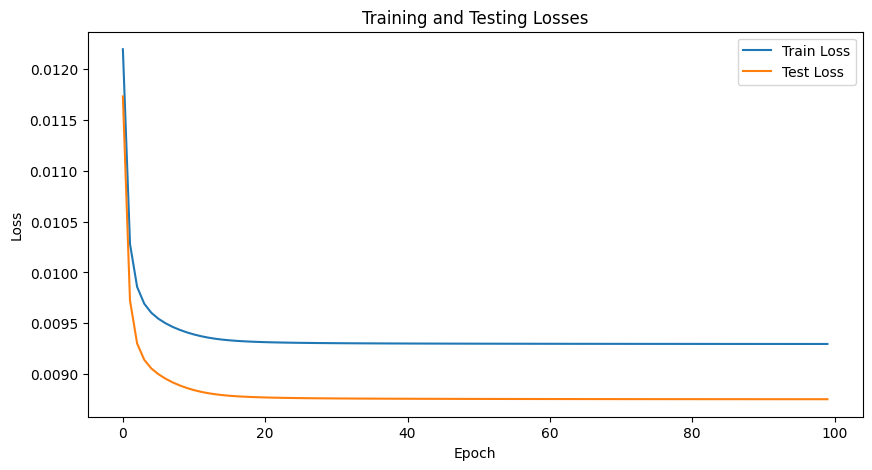

Mean Absolute Error (MAE): 60.8539
Root Mean Squared Error (RMSE): 99.80465
Forecasts for the next 3 time steps after the dataset:
   Appliance_1
0    99.479179
1   102.643669
2   100.338715


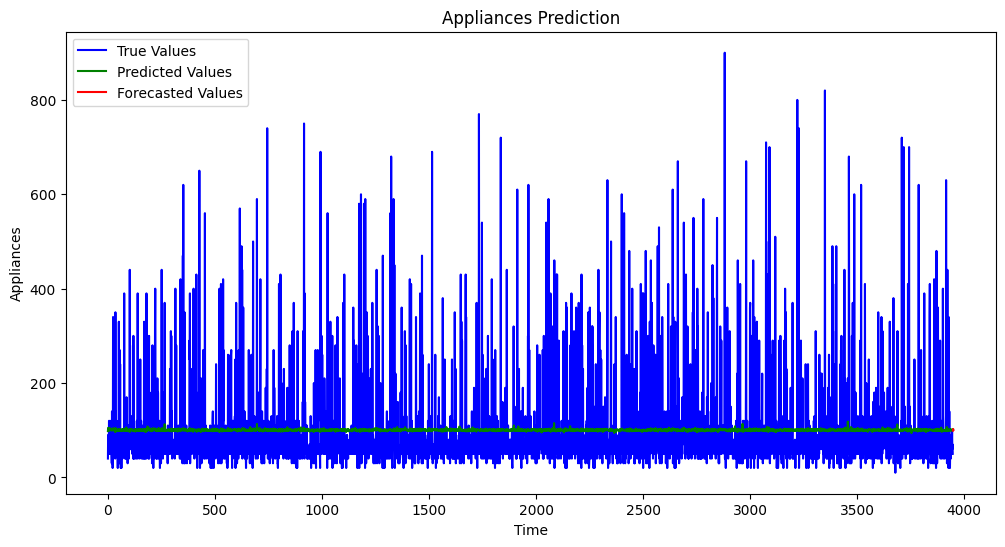

In [ ]:
# Plot training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Forecasting
model.eval()
with torch.no_grad():
    # Predictions on test set
    test_predictions = model(X_test_tensor).numpy()

# Flatten the predictions
y_pred_flattened = test_predictions.reshape(-1, 1)

# Inverse transform the predictions to get actual values
y_pred = scaler_y.inverse_transform(y_pred_flattened)

# Reshape the predictions back to match the original shape
y_pred = y_pred.reshape(test_predictions.shape[0], test_predictions.shape[1])

# Inverse transform the test targets
y_test_inverse = scaler_y.inverse_transform(y_test)

# Calculate metrics
mae = mean_absolute_error(y_test_inverse, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred))
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

# Predicting next 3 appliance columns after the dataset using LTSF method
forecasts = {}

# Loop through each appliance column
for i in range(y_pred.shape[1]):
    # Fit the forecaster to the data
    forecaster = LTSFLinearForecaster(seq_len=model.seq_len, pred_len=3)
    forecaster.fit(y_pred[:, i], fh=[1, 2, 3])

    # Predict the next 3 values
    y_pred_next = forecaster.predict()

    # Store the forecasts in the dictionary
    forecasts[f'Appliance_{i+1}'] = y_pred_next.flatten()  # Flatten the array

# Convert forecasts dictionary to DataFrame
forecasts_df = pd.DataFrame(forecasts)

# Print the forecasts
print("Forecasts for the next 3 time steps after the dataset:")
print(forecasts_df)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='True Values', color='blue')  # True values
plt.plot(y_pred, label='Predicted Values', color='green')   # Predicted values
plt.plot(len(y_test_inverse) + np.arange(3), forecasts_df.values.flatten(), label='Forecasted Values', color='red')  # Forecasted values
plt.title('Appliances Prediction')
plt.xlabel('Time')
plt.ylabel('Appliances')
plt.legend()
plt.show()

The epoch values and their results are plotted and as per the description the  Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) and Mean squared error are also evaluated for model evaluation.Uses the LTSF method to predict the next 3 values for each appliance column.
Stores the forecasted values in a dictionary.
Visualizes the true, predicted, and forecasted appliance values on a plot.
Blue for true values, green for predicted values, and red for forecasted values.
This code essentially loads the dataset, preprocesses it, trains a Linear LTSF model, evaluates its performance, forecasts future values using the LTSF method, and visualizes the results. Thus the model is utilized and evaluated.